In [1]:
import math
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
class Body(object):
    def __init__(self, mass, x, y):
        self.mass = mass
        self.x = x
        self.y = y
        self.a = [0,0]
        self.v = [0,0]
        
    '''
    Psuedocode from: http://arborjs.org/docs/barnes-hut
    
    1. If the current node is an external node (and it is not body b), calculate the 
       force exerted by the current node on b, and add this amount to b’s net force.
    
    2. Otherwise, calculate the ratio s/d. If s/d < θ, treat this internal node as a 
       single body, and calculate the force it exerts on body b, and add this amount to 
       b’s net force.
    
    3. Otherwise, run the procedure recursively on each of the current node’s children.
    '''
    def compute_acceleration(self, tree, g, theta):
        dx = tree.x_cm - self.x
        dy = tree.y_cm - self.y
        r2 = dx*dx + dy*dy
        r = math.sqrt(r2)
        if (tree.b and tree.children == [] and r != 0) or \
           (tree.num_bodies != 0 and tree.size < r * theta):
            mag = g * tree.total_mass
            self.a[0] += mag * dx / r2
            self.a[1] += mag * dy / r2
        else: 
            for ch in tree.children:
                self.compute_acceleration(ch, g, theta)
                        
    def compute_velocity(self, time_step=1):
        if self.a:
            self.v = [0,0]
            self.v[0] += self.a[0] * time_step
            self.v[1] += self.a[1] * time_step

In [3]:
class QuadTree(object):
    def __init__(self, x_min, x_max, y_min, y_max):
        self.b = None
        self.num_bodies = 0
        self.total_mass = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_mid = (self.x_min + self.x_max) / 2
        self.y_mid = (self.y_min + self.y_max) / 2
        self.size = x_max - x_min
        self.x_cm = 0
        self.y_cm = 0
        self.children = []
        
    def get_quadrant_index(self, b):
        if b.y > self.y_mid:
            if b.x > self.x_mid:
                return 0 # Q1
            else: 
                return 1 # Q2
        else:
            if b.x < self.x_mid:
                return 2 # Q3
            else:
                return 3 # Q4
    
    def subdivide(self):
        self.children = [QuadTree(self.x_mid, self.x_max, self.y_mid, self.y_max),
                         QuadTree(self.x_min, self.x_mid, self.y_mid, self.y_max),
                         QuadTree(self.x_min, self.x_mid, self.y_min, self.y_mid),
                         QuadTree(self.x_mid, self.x_max, self.y_min, self.y_mid)]
    
    def insert(self, b):
        b_idx = self.get_quadrant_index(b)
        if self.num_bodies == 0:
            self.b = b
        elif self.children:
            self.children[b_idx].insert(b)
        else:
            self.subdivide()
            c_idx = self.get_quadrant_index(self.b)
            self.children[c_idx].insert(self.b)
            self.b = None
            self.children[b_idx].insert(b)
        self.num_bodies += 1 
    
    def compute_cm(self):
        if self.b:
            self.total_mass = self.b.mass
            self.x_cm = self.b.x
            self.y_cm = self.b.y
        else:
            for ch in self.children:
                ch.compute_cm()
                self.total_mass += ch.total_mass
            for ch in self.children:
                weight = ch.total_mass / self.total_mass
                self.x_cm += ch.x_cm * weight
                self.y_cm += ch.y_cm * weight

In [4]:
size = 1000
G_CONST = 0.005
THOLD = 0.5
bodies = [
    Body(1, -633.6373382558902, 487.8061787897486),
    Body(1, 629.868336160597, -815.5256700699658),
    Body(1, 921.7376786303696, 496.6790647203113),
    Body(1, -889.3895517420744, -199.29829383909305),
    Body(1, -706.5324736899241, -160.52358780648808),
    Body(1, -562.6928724218519, 923.7505782607432),
    Body(1, 501.64886988758553, -107.02306428005431),
    Body(1, 417.21372899319886, 714.3554901176412),
    Body(1, -593.2489401107308, 422.8464200209098),
    Body(1, 589.9171624527849, 875.2736798362548)
]

def create_bodies(num_bodies=10):
    for i in range(num_bodies):
        bodies.append(Body(1, \
                           random.uniform(-size, size), \
                           random.uniform(-size, size)))
    return bodies

def build_tree():
    root = QuadTree(-size, size, -size, size)
    for b in bodies: 
        root.insert(b)
    root.compute_cm()
    for b in bodies:
        b.compute_acceleration(root, g=G_CONST, theta=THOLD)
        b.compute_velocity()
    return root

In [5]:
for b in bodies:
    print(b.mass, b.x, b.y)

1 -633.6373382558902 487.8061787897486
1 629.868336160597 -815.5256700699658
1 921.7376786303696 496.6790647203113
1 -889.3895517420744 -199.29829383909305
1 -706.5324736899241 -160.52358780648808
1 -562.6928724218519 923.7505782607432
1 501.64886988758553 -107.02306428005431
1 417.21372899319886 714.3554901176412
1 -593.2489401107308 422.8464200209098
1 589.9171624527849 875.2736798362548


In [6]:
build_tree()

In [7]:
for b in bodies:
    print(
        '\nacceleration:', b.a[0], b.a[1], 
        '\nvelocity:', b.v[0], b.v[1]
    )


acceleration: 4.994527460622609e-05 -5.9959073560917956e-05 
velocity: 4.994527460622609e-05 -5.9959073560917956e-05

acceleration: -1.206406358417151e-05 2.5203988145842467e-05 
velocity: -1.206406358417151e-05 2.5203988145842467e-05

acceleration: -3.4247506504996344e-05 6.014607941426543e-07 
velocity: -3.4247506504996344e-05 6.014607941426543e-07

acceleration: 4.642187369262468e-05 2.6044387491394728e-05 
velocity: 4.642187369262468e-05 2.6044387491394728e-05

acceleration: -8.25442604138985e-06 1.866556961340652e-05 
velocity: -8.25442604138985e-06 1.866556961340652e-05

acceleration: 1.1813200569370845e-05 -3.620823969300134e-05 
velocity: 1.1813200569370845e-05 -3.620823969300134e-05

acceleration: -1.2289981346280964e-05 1.5342932986789066e-05 
velocity: -1.2289981346280964e-05 1.5342932986789066e-05

acceleration: 5.573016360860583e-06 -3.5744976556188515e-06 
velocity: 5.573016360860583e-06 -3.5744976556188515e-06

acceleration: -2.1364050932841353e-05 4.9698766648455735e-0

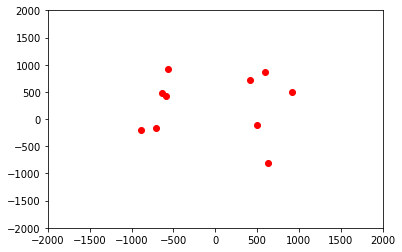

In [8]:
plt_size = 2 * size
plt.axes(xlim=(-plt_size, plt_size), ylim=(-plt_size, plt_size))
for b in bodies:
    plt.plot(b.x, b.y, 'ro')
plt.show()